# Using the selected countries quarterly data:
## Understanding the relationship/s between MEVs

**Fourth Stage** testing Deep learning algorithms, specifically RNN - LSTM

- Hyperparameter tuninng (keras tuner)
- Manually building LSTM

* Since we got bad results when using scaling only, we'll try additionally to:
  * Take the log
  * BatchNormalization
* Try Keras tuner to find good parameters:

**Import Libraries**

In [24]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.5 MB/s 


In [25]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import kerastuner as kt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
print('TF Version:', tf.__version__)

TF Version: 2.8.2


**Upload datasets**

In [3]:
mev = pd.read_csv('MEV_Selected_top_countries.csv',sep=";")

In [4]:
mev.head()

,Date,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,...,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index,Unnamed: 25
0,1975-01-01,2370600,9.012579,NaN,63.2476,1616.116,52.566667,8.27,60.02,167572,...,36.2205,26777,14.043801,3.969991,5.4978,NaN,39.142725,3.6,128.1556,NaN
1,1975-04-01,2583900,9.738219,NaN,65.3178,1651.853,53.200000,8.87,60.96,173748,...,35.7642,28090,15.371077,4.339689,5.6187,NaN,39.903834,4.2,127.2398,NaN
2,1975-07-01,2690300,10.384638,NaN,67.5589,1709.820,54.266667,8.47,61.16,182328,...,35.4102,29219,16.046223,4.699658,5.7999,NaN,40.208277,4.3,126.3735,NaN
3,1975-10-01,2898800,10.810701,NaN,69.3324,1761.831,55.266667,8.30,62.22,188532,...,35.2497,30850,16.598615,5.071648,5.8603,NaN,40.512721,4.2,125.2582,NaN
4,1976-01-01,3275500,11.030391,NaN,69.9437,1820.487,55.900000,7.73,62.86,196288,...,34.4582,32405,17.197039,5.298913,5.9812,NaN,41.186845,4.1,123.4281,NaN


**General cleaning**

In [5]:
mev = mev.iloc[:,:-1]
mev['Date'] = pd.to_datetime(mev['Date'], format='%Y-%m-%d')

mev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    188 non-null    datetime64[ns]
 1   Korea_Nominal_GDP                       188 non-null    int64         
 2   Korea_CPI                               188 non-null    float64       
 3   Korea_Unemployment_rate                 128 non-null    float64       
 4   Korea_Residential_property_index        188 non-null    float64       
 5   US_Nominal_GDP                          188 non-null    float64       
 6   US_CPI                                  188 non-null    float64       
 7   US_Unemployment_rate                    188 non-null    float64       
 8   US_Residential_property_index           188 non-null    float64       
 9   Canada_Nominal_GDP                      188 non-null  

In [6]:
mev.isnull().sum()

Date                                       0
Korea_Nominal_GDP                          0
Korea_CPI                                  0
Korea_Unemployment_rate                   60
Korea_Residential_property_index           0
US_Nominal_GDP                             0
US_CPI                                     0
US_Unemployment_rate                       0
US_Residential_property_index              0
Canada_Nominal_GDP                         0
Canada_CPI                                 0
Canada_Unemployment_rate                   0
Canada_Residential_property_index          0
Switzerland_Nominal_GDP                   20
Switzerland_CPI                            0
Switzerland_Unemployment_rate              0
Switzerland_Residential_property_index     0
UK_Nominal_GDP                             0
UK_CPI                                     0
UK_Unemployment_rate                       0
UK_Residential_property_index              0
D_Nominal_GDP                             64
D_CPI     

**3 columns are missing data due to reporting time horizon difference**

In [7]:
impute = SimpleImputer(strategy='mean')

mev_imputed = pd.DataFrame(impute.fit_transform(mev.iloc[:,1:]), columns=mev.iloc[:,1:].columns)
mev_imputed['Date'] = mev['Date']
mev_imputed.head()

,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,Canada_CPI,...,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index,Date
0,2370600.0,9.012579,3.509115,63.2476,1616.116,52.566667,8.27,60.02,167572.0,21.991046,...,36.2205,26777.0,14.043801,3.969991,5.4978,619115.241935,39.142725,3.6,128.1556,1975-01-01
1,2583900.0,9.738219,3.509115,65.3178,1651.853,53.200000,8.87,60.96,173748.0,22.517777,...,35.7642,28090.0,15.371077,4.339689,5.6187,619115.241935,39.903834,4.2,127.2398,1975-04-01
2,2690300.0,10.384638,3.509115,67.5589,1709.820,54.266667,8.47,61.16,182328.0,23.255201,...,35.4102,29219.0,16.046223,4.699658,5.7999,619115.241935,40.208277,4.3,126.3735,1975-07-01
3,2898800.0,10.810701,3.509115,69.3324,1761.831,55.266667,8.30,62.22,188532.0,23.729260,...,35.2497,30850.0,16.598615,5.071648,5.8603,619115.241935,40.512721,4.2,125.2582,1975-10-01
4,3275500.0,11.030391,3.509115,69.9437,1820.487,55.900000,7.73,62.86,196288.0,24.071635,...,34.4582,32405.0,17.197039,5.298913,5.9812,619115.241935,41.186845,4.1,123.4281,1976-01-01


In [8]:
mev_imputed.isnull().sum()

Korea_Nominal_GDP                         0
Korea_CPI                                 0
Korea_Unemployment_rate                   0
Korea_Residential_property_index          0
US_Nominal_GDP                            0
US_CPI                                    0
US_Unemployment_rate                      0
US_Residential_property_index             0
Canada_Nominal_GDP                        0
Canada_CPI                                0
Canada_Unemployment_rate                  0
Canada_Residential_property_index         0
Switzerland_Nominal_GDP                   0
Switzerland_CPI                           0
Switzerland_Unemployment_rate             0
Switzerland_Residential_property_index    0
UK_Nominal_GDP                            0
UK_CPI                                    0
UK_Unemployment_rate                      0
UK_Residential_property_index             0
D_Nominal_GDP                             0
D_CPI                                     0
D_Unemployment_rate             

**Transforming Data to fit RNN model**

In [9]:
train_dates = mev_imputed['Date']

cols = list(mev_imputed)[:-1]

df_training_noDate = mev_imputed[cols].astype(float)

df_training_noDate.head(2)

,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,Canada_CPI,...,Switzerland_Unemployment_rate,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index
0,2370600.0,9.012579,3.509115,63.2476,1616.116,52.566667,8.27,60.02,167572.0,21.991046,...,0.08,36.2205,26777.0,14.043801,3.969991,5.4978,619115.241935,39.142725,3.6,128.1556
1,2583900.0,9.738219,3.509115,65.3178,1651.853,53.200000,8.87,60.96,173748.0,22.517777,...,0.24,35.7642,28090.0,15.371077,4.339689,5.6187,619115.241935,39.903834,4.2,127.2398


In [10]:
for c in [col for col in df_training_noDate.columns if 'GDP' in col]:
  df_training_noDate[c] = np.log(df_training_noDate[c])

In [11]:
df_training_noDate.head(2)

,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,Canada_CPI,...,Switzerland_Unemployment_rate,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index
0,14.678654,9.012579,3.509115,63.2476,7.387781,52.566667,8.27,60.02,12.029168,21.991046,...,0.08,36.2205,10.195299,14.043801,3.969991,5.4978,13.336047,39.142725,3.6,128.1556
1,14.764810,9.738219,3.509115,65.3178,7.409653,53.200000,8.87,60.96,12.065361,22.517777,...,0.24,35.7642,10.243169,15.371077,4.339689,5.6187,13.336047,39.903834,4.2,127.2398


In [12]:
# X = df_training.drop(columns='Korea_Nominal_GDP')
# y = df_training['Korea_Nominal_GDP']



test_size = 30
validate_size = 10

df_train = df_training_noDate[:-test_size]
df_test = df_training_noDate[-test_size:]
df_validate = df_train[-validate_size:]


df_train.shape, df_test.shape, df_validate.shape
# X_train = X[:-test_size]
# X_test = X[-test_size:]
# X_validate = X_train[-validate_size:]


# y_train = y[:-test_size]
# y_test = y[-test_size:]
# y_validate = y_train[-validate_size:]


# X_train.shape, X_test.shape, X_validate.shape
#y_train.shape, y_test.shape, y_validate.shape

((158, 24), (30, 24), (10, 24))

In [13]:
# y_train.shape

In [14]:
scaler = StandardScaler()

training_scaled = scaler.fit_transform(df_train)
val_scaled = scaler.transform(df_validate)
test_scaled = scaler.transform(df_test)

In [15]:
# training_features_scaled

# LSTM

**Building the dataset in LSTM accepted format**

In [16]:
n_future = 1
n_past = 5

# training
X_training = []
y_training = []


for i in range(n_past, len(training_scaled) - n_future +1):
  X_training.append(training_scaled[i - n_past: i, 0: df_train.shape[1]])
  y_training.append(training_scaled[i + n_future -1 : i + n_future, 0])


X_training, y_training = np.array(X_training), np.array(y_training)


# test
X_test = []
y_test = []


for i in range(n_past, len(test_scaled) - n_future +1):
  X_test.append(test_scaled[i - n_past: i, 0: df_test.shape[1]])
  y_test.append(test_scaled[i + n_future -1 : i + n_future, 0])

X_test, y_test = np.array(X_test), np.array(y_test)


# validation set
X_validate = []
y_validate = []


for i in range(n_past, len(val_scaled) - n_future +1):
  X_validate.append(val_scaled[i - n_past: i, 0: df_validate.shape[1]])
  y_validate.append(val_scaled[i + n_future -1 : i + n_future, 0])

X_validate, y_validate = np.array(X_validate), np.array(y_validate)


X_training.shape, y_training.shape, X_test.shape, y_test.shape, X_validate.shape, y_validate.shape

((153, 5, 24), (153, 1), (25, 5, 24), (25, 1), (5, 5, 24), (5, 1))

In [19]:
METRICS = [
      tf.keras.metrics.MeanSquaredError(),
      tf.keras.metrics.RootMeanSquaredError(),
      tf.keras.metrics.MeanAbsoluteError()]


def make_model(hp, metrics = METRICS):  

  model = tf.keras.Sequential()
  
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 16)
  model.add(tf.keras.layers.LSTM(units = hp_units, input_shape =(X_training.shape[1],X_training.shape[2]), 
                              dropout = 0.25))

  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 1
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 2
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 3
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 4

  model.add(tf.keras.layers.Dropout(0.25)) 

  model.add(tf.keras.layers.Dense(y_training.shape[1]))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = tf.keras.losses.MeanSquaredError(),
                metrics = metrics)
  
  return model

In [30]:
tuner = kt.Hyperband(make_model,
                     objective ='val_loss',
                     max_epochs = 10,
                     factor = 3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [31]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [32]:
tuner.search(x=X_training, y=y_training, epochs=50, batch_size=32, 
             validation_data=(X_validate, y_validate), callbacks=[ClearTrainingOutput()])
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")






Trial 30 Complete [00h 00m 05s]
val_loss: 0.0010460984194651246

Best val_loss So Far: 4.131882087676786e-05
Total elapsed time: 00h 02m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the densely-connected
layer is 496 and the optimal learning rate for the optimizer
is 0.01.



In [33]:
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(X_training, y_training,
             epochs=50,
             validation_data=(X_validate, y_validate))

Epoch 1/50
5/5 [==============================] - 3s 217ms/step - loss: 259.1409 - mean_squared_error: 250.9402 - root_mean_squared_error: 15.8411 - mean_absolute_error: 8.3626 - val_loss: 1.8769 - val_mean_squared_error: 1.8769 - val_root_mean_squared_error: 1.3700 - val_mean_absolute_error: 1.3699
Epoch 2/50
5/5 [==============================] - 0s 74ms/step - loss: 0.8396 - mean_squared_error: 0.8396 - root_mean_squared_error: 0.9163 - mean_absolute_error: 0.7993 - val_loss: 0.4814 - val_mean_squared_error: 0.4814 - val_root_mean_squared_error: 0.6939 - val_mean_absolute_error: 0.6938
Epoch 3/50
5/5 [==============================] - 0s 73ms/step - loss: 0.4139 - mean_squared_error: 0.4139 - root_mean_squared_error: 0.6434 - mean_absolute_error: 0.5088 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_root_mean_squared_error: 0.2254 - val_mean_absolute_error: 0.2253
Epoch 4/50
5/5 [==============================] - 0s 76ms/step - loss: 0.2739 - mean_squared_error: 0.2739 - 

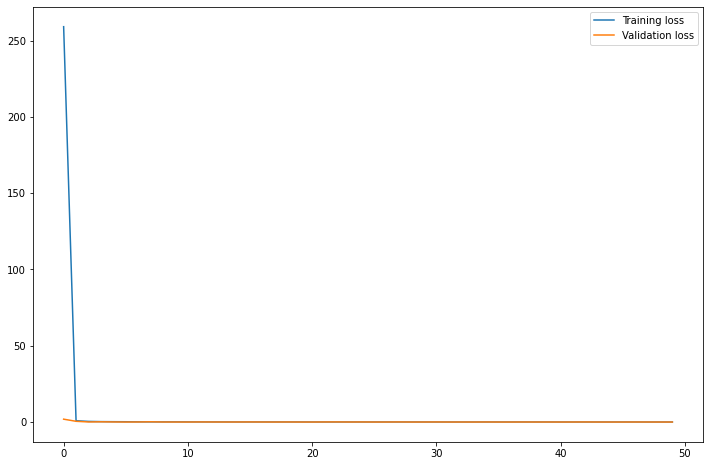

In [35]:
plt.figure(figsize=(12,8))
plt.plot(baseline_history.history['loss'], label='Training loss')
plt.plot(baseline_history.history['val_loss'], label='Validation loss')
plt.legend()

In [39]:
n_future = test_size - n_past

forecast_dates = mev_imputed['Date'].iloc[-n_future:]

forecast_dates.shape

(25,)

In [40]:
pred = model.predict(X_test)

#pred = model.predict(X_training[-n_future:])

prediction_copies = np.repeat(pred, df_test.shape[1], axis=-1)
prediction_copies.shape

y_pred_unscaled = scaler.inverse_transform(prediction_copies)[:,0]
y_pred = np.exp(y_pred_unscaled)

y_pred.shape, X_test.shape

((25,), (25, 5, 24))

In [41]:
df_forecast = pd.DataFrame({'Date':forecast_dates, 'Predicted':y_pred})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

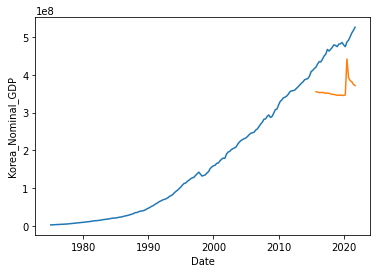

In [43]:
sns.lineplot(mev_imputed['Date'],mev_imputed['Korea_Nominal_GDP'])
sns.lineplot(df_forecast['Date'],df_forecast['Predicted'])

In [52]:
mev_imputed2 = mev_imputed[['Date','Korea_Nominal_GDP']][-n_future:]
both = df_forecast.merge(mev_imputed2, left_on='Date', right_on='Date')
both = both.set_index('Date')

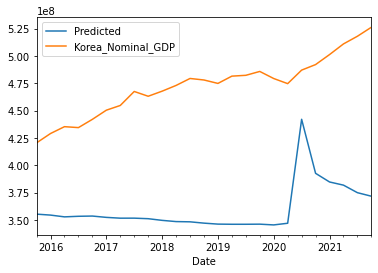

In [53]:
both.plot.line()

In [54]:
both

,Predicted,Korea_Nominal_GDP
Date,,
2015-10-01,355279584.0,420497400.0
2016-01-01,354404448.0,429035900.0
2016-04-01,352787840.0,435295100.0
2016-07-01,353313760.0,434442600.0
2016-10-01,353526112.0,442006000.0
2017-01-01,352318464.0,450374800.0
2017-04-01,351582752.0,454700500.0
2017-07-01,351606208.0,467491900.0
2017-10-01,351112288.0,463131100.0


-------------------------------
**Manual building of LSTM, using less complex structure, to be used as threshold**

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(64, activation = 'relu', 
                               input_shape=(X_training.shape[1],X_training.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation = 'relu', return_sequences=False))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(y_training.shape[1]))

In [ ]:
model.compile(optimizer='adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 64)             22784     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 35,233
Trainable params: 35,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_training, y_training, 
                    epochs=50, batch_size=16, 
                    validation_data=(X_validate, y_validate ), verbose=1)

Epoch 1/50
10/10 [==============================] - 3s 57ms/step - loss: 0.4525 - val_loss: 0.8594
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 0.1716 - val_loss: 0.5511
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.1445 - val_loss: 0.0480
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0845 - val_loss: 0.0705
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0650 - val_loss: 0.0299
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0524 - val_loss: 0.0038
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0433 - val_loss: 9.5166e-04
Epoch 8/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0388 - val_loss: 0.0135
Epoch 9/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0348 - val_loss: 0.0066
Epoch 10/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0304 - val_loss: 0.0086
Epoch

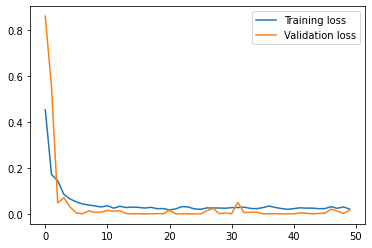

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
n_future = test_size - n_past

forecast_dates = mev_imputed['Date'].iloc[-n_future:]

forecast_dates.shape

[Timestamp('2015-12-31 00:00:00', freq='Q-DEC'),
 Timestamp('2016-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2016-06-30 00:00:00', freq='Q-DEC'),
 Timestamp('2016-09-30 00:00:00', freq='Q-DEC'),
 Timestamp('2016-12-31 00:00:00', freq='Q-DEC'),
 Timestamp('2017-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2017-06-30 00:00:00', freq='Q-DEC'),
 Timestamp('2017-09-30 00:00:00', freq='Q-DEC'),
 Timestamp('2017-12-31 00:00:00', freq='Q-DEC'),
 Timestamp('2018-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2018-06-30 00:00:00', freq='Q-DEC'),
 Timestamp('2018-09-30 00:00:00', freq='Q-DEC'),
 Timestamp('2018-12-31 00:00:00', freq='Q-DEC'),
 Timestamp('2019-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2019-06-30 00:00:00', freq='Q-DEC'),
 Timestamp('2019-09-30 00:00:00', freq='Q-DEC'),
 Timestamp('2019-12-31 00:00:00', freq='Q-DEC'),
 Timestamp('2020-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2020-06-30 00:00:00', freq='Q-DEC'),
 Timestamp('2020-09-30 00:00:00', freq='Q-DEC'),
 Timestamp('2020-12-

In [ ]:
pred = model.predict(X_test)

#pred = model.predict(X_training[-n_future:])

prediction_copies = np.repeat(pred, df_test.shape[1], axis=-1)
prediction_copies.shape

y_pred_unscaled = scaler.inverse_transform(prediction_copies)[:,0]
y_pred = np.exp(y_pred_unscaled)

y_pred.shape, X_test.shape


((25,), (25, 5, 24))

In [ ]:
len(np.array(forecast_dates)), len(y_pred)

(25, 25)

In [ ]:
df_forecast = pd.DataFrame({'Date':forecast_dates, 'Predicted':y_pred})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [ ]:
mev_imputed2 = mev_imputed[['Date','Korea_Nominal_GDP']]

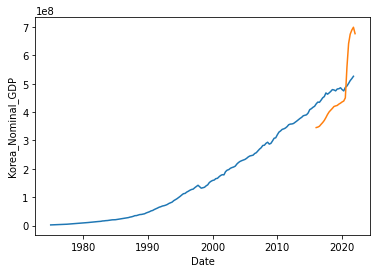

In [ ]:
sns.lineplot(mev_imputed['Date'],mev_imputed['Korea_Nominal_GDP'])
sns.lineplot(df_forecast['Date'],df_forecast['Predicted'])

In [ ]:
df_forecast

,Date,Predicted
0,2015-12-31,443617344.0
1,2016-03-31,440476640.0
2,2016-06-30,437530048.0
3,2016-09-30,443580928.0
4,2016-12-31,449528544.0
5,2017-03-31,455019168.0
6,2017-06-30,466853856.0
7,2017-09-30,483530048.0
8,2017-12-31,499725568.0
9,2018-03-31,510346272.0


In [ ]:
mev_imputed[['Date', 'Korea_Nominal_GDP']].tail(10)

,Date,Korea_Nominal_GDP
178,2019-07-01,482285700.0
179,2019-10-01,485821000.0
180,2020-01-01,479344300.0
181,2020-04-01,474669500.0
182,2020-07-01,487038500.0
183,2020-10-01,492100100.0
184,2021-01-01,501248100.0
185,2021-04-01,511003200.0
186,2021-07-01,518021300.0
187,2021-10-01,526257600.0


#End